In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

In [2]:
import os

os.makedirs('utils/', exist_ok=True)
os.chdir('utils')

! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/models.py
! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/losses.py
! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/vision.py
! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/callbacks.py
! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/utils.py
! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/attention_modules.py

os.chdir('/content')
print("Current working directory", os.getcwd())

Current working directory /content


In [3]:
from utils import vision
from utils import utils
from utils import losses
from utils.attention_modules import Conv2DLayerBN, Conv2DLayerRes, ChannelGate, SpatialGate, CBAM

In [43]:
experiment = {
    'TYPE': 'train',        # Experiment type: 'train', 'test'
    'ACCELERATOR': 'GPU',   # 'GPU' or 'TPU'

    'IMAGE_SIZE': (224, 224),
    'INPUT_SHAPE': (224, 224, 3),
    'VALID_SIZE': 0.2,      # Validation data size: (Valid Data) / (All Data)
    'DATA_AUG': False,       # Apply data augmentation

    'BACKBONE': 'ResNet50',        # 'custom', 'VGG16', 'VGG19', 'ResNet50' - default 'custom'
    'LAST_TRANIABLE_LAYERS': 5,  # number of last trainable layers of pre-trained backbone models, fine-tuning
    'BATCH_SIZE': 32,            # IF TPU is active set 4, otherwise set anything
    'EPOCHS': 100,
    'OPTIMIZER': 'Adam',
    'LEARNING_RATE': 1e-4,

    'SIAMESE_NETWORK': False,  # Siamese Network or CNN
    #'RECONS_LOSS': 'PERCEPTUAL',  # Reconstruction loss ('SSIM', 'MSE', 'MAE', 'PERCEPTUAL')
    #'PERCEPTUAL_LAYERS': [5,8,13,18],    # [5,8,13,18], None
    #'PERCEP_LOSS_MODEL': 'VGG19', # custom', 'VGG16', 'VGG19' - default 'VGG16'
    #'PERP_LOSS_LAMBDA': 1,
    #'LRELU_SLOPE': 0.2,       # Leaky ReLU activation function slope value
    #'MSE_LOSS_LAMBDA': 0.01,  # MSE coeff

    # set the dimensionality of the latent space to a plane for visualization later
    'LATENT_DIM': 224,
}

In [5]:
# MVTec Transistor dataset from Kaggle
# https://www.kaggle.com/datasets/leezhixiong/mvtec-transistor-dataset

! pip install -q kaggle

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d leezhixiong/mvtec-transistor-dataset

100% 384M/384M [00:23<00:00, 14.5MB/s]
100% 384M/384M [00:23<00:00, 16.9MB/s]


In [6]:
utils.unzip_data("/content/mvtec-transistor-dataset.zip")

! rm /content/mvtec-transistor-dataset.zip

In [7]:
defect_types = ["bent_lead", "cut_lead", "damaged_case", "misplaced"]

In [8]:
LABELS = ["Defect-free", "Defected"]

In [9]:
TRAIN_DATASET_DIR = "/content/transistor/train/good"
DEFECTED_DATA_BASE_DIR = "/content/transistor/test"

In [10]:
defected_data_paths = []
defected_image_files = []

# Get all defected images' directories
for defect_type in defect_types:
    defected_data_paths.append(os.path.join(DEFECTED_DATA_BASE_DIR, defect_type))

# Get defect free images
defect_free_image_files = utils.get_image_file_list(TRAIN_DATASET_DIR, ext='png')

# Get defected images
for path in defected_data_paths:
    defected_image_files += utils.get_image_file_list(path, ext='png')

# Training/Test Split
train_test_separator = len(defect_free_image_files) - int(len(defect_free_image_files) * experiment['VALID_SIZE'])
train_defect_free_image_files = defect_free_image_files[:train_test_separator]
test_defect_free_image_files = defect_free_image_files[train_test_separator:]

train_test_separator = len(defected_image_files) - int(len(defected_image_files) * experiment['VALID_SIZE'])
train_defected_image_files = defected_image_files[:train_test_separator]
test_defected_image_files = defected_image_files[train_test_separator:]


print(f"Number of defect free Transistor images in training dataset: {len(train_defect_free_image_files)}")
print(f"Number of defect free Transistor images in testing dataset: {len(test_defect_free_image_files)}")
print(f"Number of defect free Transistor images: {len(train_defect_free_image_files)+len(test_defect_free_image_files)}")
del defect_free_image_files

print(f"\nNumber of defected Transistor images in training dataset: {len(train_defected_image_files)}")
print(f"Number of defected Transistor images in testing dataset: {len(test_defected_image_files)}")
print(f"Number of defected Transistor images: {len(test_defected_image_files)+len(train_defected_image_files)}")
del defected_image_files

print(f"\nNumber of all MVTec Transistor images: {len(train_defect_free_image_files) + len(test_defect_free_image_files) + len(test_defected_image_files)+len(train_defected_image_files)}")

Number of defect free Transistor images in training dataset: 171
Number of defect free Transistor images in testing dataset: 42
Number of defect free Transistor images: 213

Number of defected Transistor images in training dataset: 32
Number of defected Transistor images in testing dataset: 8
Number of defected Transistor images: 40

Number of all MVTec Transistor images: 253


In [44]:
# Training
train_defect_free_images = utils.load_and_prepare_images(img_file_list=train_defect_free_image_files, img_size=experiment['IMAGE_SIZE'], scl=True)
train_defected_images = utils.load_and_prepare_images(img_file_list=train_defected_image_files, img_size=experiment['IMAGE_SIZE'], scl=True)
# Testing
test_defect_free_images = utils.load_and_prepare_images(img_file_list=test_defect_free_image_files, img_size=experiment['IMAGE_SIZE'], scl=True)
test_defected_images = utils.load_and_prepare_images(img_file_list=test_defected_image_files, img_size=experiment['IMAGE_SIZE'], scl=True)

In [45]:
# Setup data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"), # randomly flip images on horizontal/vertical edge
  #preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
  #preprocessing.RandomZoom(0.2), # randomly zoom into an image
  tf.keras.layers.RandomBrightness(factor=0.2, value_range=[0.0, 1.0], seed=None),
  # value_range parameter should be [0.0, 1.0] for RandomBrightness
  # if images were scaled before, default value is [0,255]
  tf.keras.layers.RandomContrast(0.2, seed=None),
  #tf.keras.layers.RandomCrop(256, 256, seed=None), Error - Image size changes
  #preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
  #preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
  #preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
], name="data_augmentation")

In [46]:
def apply_data_augmentation(images, data_aug_layer, factor=1):
    temp_images = images

    def data_aug(image):
        image = data_aug_layer(image)
        return tf.clip_by_value(image, 0.0, 1.0)

    for _ in range(factor):
        aug_images = data_aug(temp_images)
        images = np.concatenate((images, aug_images.numpy()), axis=0)

    return images

Apply Data Augmentation to defected images to construct balanced dataset

In [47]:
train_defected_images = apply_data_augmentation(train_defected_images,
                                                data_augmentation,
                                                factor=(train_defect_free_images.shape[0] // train_defected_images.shape[0]))

np.random.shuffle(train_defected_images)

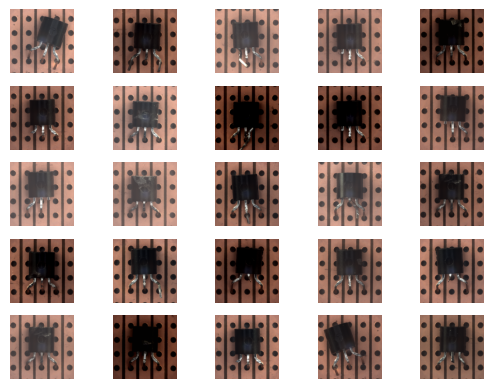

In [48]:
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(train_defected_images[i])
    plt.axis("off")

In [49]:
import random as rnd

def create_dataset_pipeline(defect_free_imgs, defected_imgs, shuffle=False):
    images = []
    labels = []

    for index, img_file in enumerate(defect_free_imgs):
        images.append(img_file)
        labels.append(0)

    for index, img_file in enumerate(defected_imgs):
        images.append(img_file)
        labels.append(1)

    indices = list(range(len(images)))
    if shuffle:
        rnd.shuffle(indices)

    shuffled_images = [images[i] for i in indices]
    shuffled_labels = [labels[i] for i in indices]

    X_train, y_train = np.array(shuffled_images), np.array(shuffled_labels)

    return X_train, y_train

In [50]:
from tensorflow.keras.utils import to_categorical

if experiment['SIAMESE_NETWORK']:
    x_train_class = [train_defect_free_images, train_defected_images]
    x_test_class = [test_defect_free_images, test_defected_images]
else:  # CNN
    X_train, y_train = create_dataset_pipeline(train_defect_free_images, train_defected_images, shuffle=True)
    X_test, y_test = create_dataset_pipeline(test_defect_free_images, test_defected_images, shuffle=True)

    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

del train_defect_free_images
del train_defected_images
del test_defect_free_images
del test_defected_images

In [51]:
import random as rnd

def create_siamese_dataset_pairs(data_pair, max_min_ix="min", verbose=0):
    pairs = []
    labels_arr = []
    num_class = len(data_pair)

    assert ((max_min_ix == "min") or (max_min_ix == "max"))

    def get_rnd_other_element(element_id, length):
        inc = rnd.randrange(1, length)
        return ((element_id + inc) % length)

    if max_min_ix == "min":
        element_num = min([len(data_pair[ix]) for ix in range(num_class)])-1
    else:  # "max"
        element_num = max([len(data_pair[ix]) for ix in range(num_class)])-1

    if verbose > 0:
        print(f"Number of maximum elements to be matched: {element_num}")

    for class_id in range(num_class):
        for ix in range(element_num):
            # Select other classes randomaly
            other_class_id = get_rnd_other_element(class_id, num_class)
            if verbose > 0:
                print(f"\nClass Id: {class_id}")
                print(f"Class length: {len(data_pair[class_id])}")

            # Set element index. Note that element index value can not be higher than
            # the legth of data array
            element_ix = ix % len(data_pair[class_id])
            if verbose > 0:
                print(f"element_ix: {element_ix}")

            # Select ramndom element index for base class
            rnd_ix = get_rnd_other_element(element_ix, len(data_pair[class_id]))
            if verbose > 0:
                print(f"rnd_ix: {rnd_ix}")
            # Select random element index for other class
            other_rnd_ix = get_rnd_other_element(element_ix, len(data_pair[other_class_id]))
            if verbose > 0:
                print(f"other_rnd_ix: {other_rnd_ix}")

            pairs += [[data_pair[class_id][element_ix], data_pair[class_id][rnd_ix]]]
            pairs += [[data_pair[class_id][element_ix], data_pair[other_class_id][other_rnd_ix]]]

            labels_arr += [1,0]

    return np.array(pairs), np.array(labels_arr)

In [52]:
if experiment['SIAMESE_NETWORK']:
    training_data_pairs, y_train = create_siamese_dataset_pairs(x_train_class)
    del x_train_class
    testing_data_pairs, y_test = create_siamese_dataset_pairs(x_test_class)
    del x_test_class

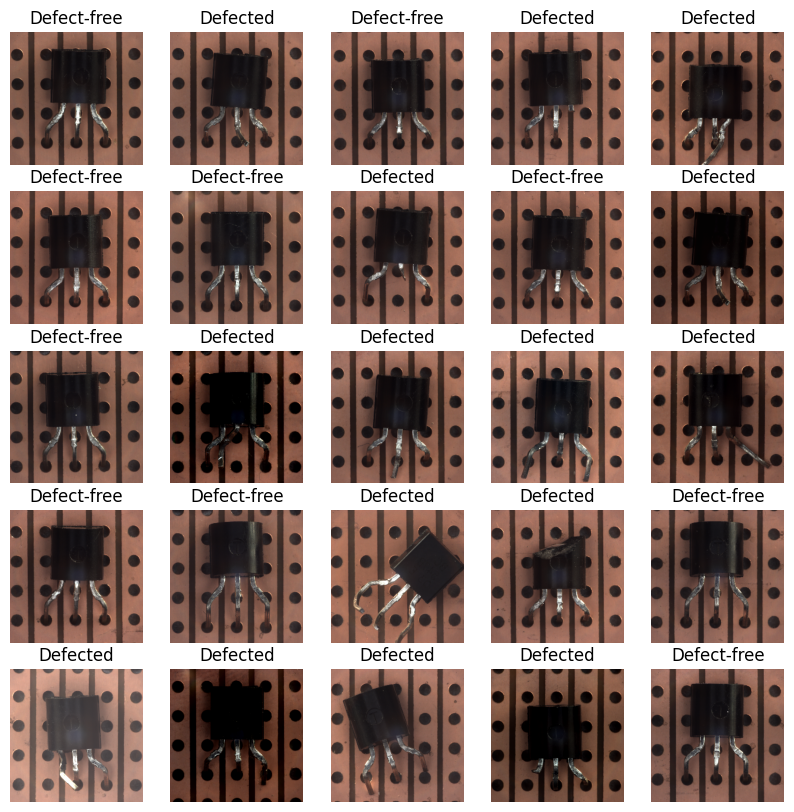

In [53]:
plt.figure(figsize=(10, 10))
if experiment['SIAMESE_NETWORK']:
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(training_data_pairs[i,i%2,:,:,:])
        plt.title(LABELS[i%2])
        plt.axis("off")
else:
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(X_train[i])
        plt.title(LABELS[np.argmax(y_train[i])])
        plt.axis("off")

In [54]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [55]:
#from keras_attention import AttentionAugmentation2D

def create_ResNet50_model(input_shape, output_dim, first_trainable_layer_ix=None,
                          attention_layers=None, verbose=0):
    resnet50_model = tf.keras.applications.resnet.ResNet50(weights="imagenet",
                                                     input_shape=input_shape,
                                                     include_top=False
                                                     )
    apply_attention = False
    # Check attention_layers parameter
    if attention_layers != None:
        assert(isinstance(attention_layers, tuple) or isinstance(attention_layers, list))
        if first_trainable_layer_ix > min(attention_layers):
            raise ValueError(f"Attention module can not be added to layers not trainable!")
        else:
            apply_attention = True

    # Check trainable states of model's layers
    trainable = False
    for layer_ix in range(len(resnet50_model.layers)):
        if layer_ix == first_trainable_layer_ix:
            trainable = True   # Set layers as trainable after first_trainable_layer
            if verbose > 0:
                print(f"{layer_ix}. {resnet50_model.get_layer(index=layer_ix).name} layer is the first trainable layer.")
        resnet50_model.get_layer(index=layer_ix).trainable = trainable

    #if apply_attention:
    #    for layer_ix in attention_layers:
    #        x = resnet50_model.get_layer(index=layer_ix).output
    #        x = x + tf.keras.layers.Attention()([x,x])
    #        if verbose > 0:
    #            print(f"Attention block was added to {resnet50_model.get_layer(index=layer_ix).name} layer.")
#
    #    x = tf.keras.layers.Flatten()(x)
    #else:
    #    x = tf.keras.layers.Flatten()(resnet50_model.output)

    x = resnet50_model.output
    #x = x + tf.keras.layers.Attention()([x,x])
    x = CBAM(gate_channels=2048, reduction_ratio=8)(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    output = tf.keras.layers.Dense(output_dim, activation="softmax")(x)

    return tf.keras.Model(resnet50_model.input, output, name="resnet50_model")

In [56]:
# "conv5_block1_out"
FIRST_TRAINABLE_LAYER = 154

#["conv5_block1_out", "conv5_block2_out", "conv5_block3_out"]
ATTENTION_LAYERS = [154, 164, 174]

In [57]:
if experiment['SIAMESE_NETWORK']:
    resnet50_model = create_ResNet50_model(experiment['INPUT_SHAPE'], output_dim=experiment['LATENT_DIM'])
else:
    resnet50_model = create_ResNet50_model(experiment['INPUT_SHAPE'], output_dim=2,
                                       first_trainable_layer_ix=FIRST_TRAINABLE_LAYER,
                                       attention_layers=ATTENTION_LAYERS,
                                       verbose=1)

154. conv5_block1_out layer is the first trainable layer.


In [58]:
def create_SiameseResNet50_model(input_shape, backbone_model):
    input_siam1 = tf.keras.Input(shape=input_shape)   # First input img
    input_siam2 = tf.keras.Input(shape=input_shape)   # Second input img

    resnet50_model1_embed = backbone_model(input_siam1)
    resnet50_model2_embed = backbone_model(input_siam2)

    distance = tf.keras.layers.Lambda(losses.euclid_dis,
                                      output_shape=eucl_dist_output_shape)([resnet50_model1_embed, resnet50_model2_embed])

    return tf.keras.Model([input_siam1, input_siam2], distance)   # distance is the output of the model

In [59]:
if experiment['SIAMESE_NETWORK']:
    siam_resnet50_model = create_SiameseResNet50_model(experiment['INPUT_SHAPE'], resnet50_model)
    siam_resnet50_model.summary()
else:
    resnet50_model.summary()

Model: "resnet50_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                 

In [60]:
def accuracy(y_true, y_pred):
    # Compute classification accuracy with a fixed threshold on distances.
    return tf.keras.backend.mean(tf.keras.backend.equal(y_true, tf.keras.backend.cast(y_pred < 0.5, y_true.dtype)))

In [61]:
if experiment['SIAMESE_NETWORK']:
    siam_resnet50_model.compile(loss=losses.contrastive_loss,
                       optimizer=tf.keras.optimizers.Adam(learning_rate=experiment['LEARNING_RATE']),
                       metrics=[accuracy])
else:
    resnet50_model.compile(loss="categorical_crossentropy",
                       optimizer=tf.keras.optimizers.Adam(learning_rate=experiment['LEARNING_RATE']),
                       metrics=["accuracy"])

In [ ]:
if experiment['SIAMESE_NETWORK']:
    siam_model_history = siam_resnet50_model.fit([training_data_pairs[:, 0], training_data_pairs[:, 1]],
                                             y_train, batch_size=experiment['BATCH_SIZE'],
                                             epochs=experiment['EPOCHS'],
                                             validation_data=([testing_data_pairs[:, 0], testing_data_pairs[:, 1]], y_test))
else:  # CNN
    resnet50_model_history = resnet50_model.fit(X_train, y_train,
                                                batch_size=experiment['BATCH_SIZE'],
                                                epochs=experiment['EPOCHS'], verbose = 1,
                                                validation_data=(X_test, y_test))

In [63]:
def compute_accuracy(y_true, y_pred):
    # Compute classification accuracy with a fixed threshold on distances
    pred = y_pred.ravel() < 0.5    # flats the content of the array and returns the array view (reference)
    return np.mean(pred == y_true)

2/2 [==============================] - 0s 92ms/step - loss: 0.8000 - accuracy: 0.9400
Accuracy =  93.99999976158142 %


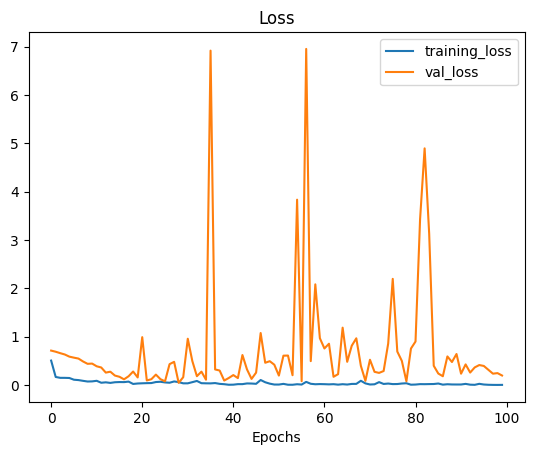

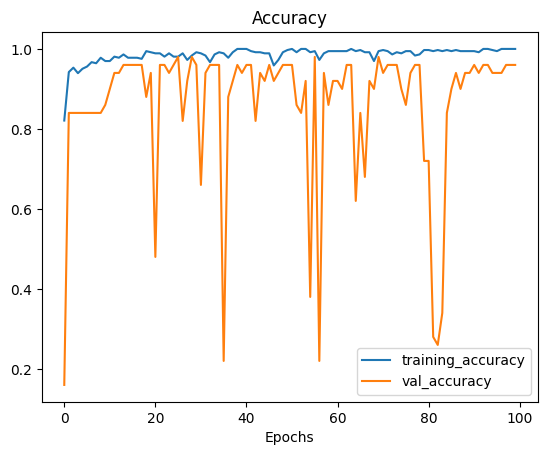

In [64]:
# compute final accuracy on training and test sets
if experiment['SIAMESE_NETWORK']:
    y_pred_train = siam_resnet50_model.predict([training_data_pairs[:, 0], training_data_pairs[:, 1]])
    tr_acc = compute_accuracy(y_train, y_pred_train)
    y_pred_test = siam_resnet50_model.predict([testing_data_pairs[:, 0], testing_data_pairs[:, 1]])
    te_acc = compute_accuracy(y_test, y_pred_test)

    print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
    print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))
else:
    vision.plot_loss_curves(resnet50_model_history, all_in_one=False)
    loss, acc = resnet50_model.evaluate(X_test, y_test)

    print("Accuracy = ", (acc * 100.0), "%")

In [65]:
y_pred_cnn = resnet50_model.predict(X_test)

# Categorical Classification
predict = lambda arr: np.argmax(arr)

y_pred_abs = np.array(list(map(predict, y_pred_cnn)))  # Absolute value of prediction
y_pred_dis = np.copy(y_pred_cnn[:,1])

y_pred_cnn[:5]

2/2 [==============================] - 1s 121ms/step


array([[1.0000000e+00, 2.3831251e-10],
       [1.0000000e+00, 4.2188591e-13],
       [5.1636877e-03, 9.9483633e-01],
       [1.0000000e+00, 4.3432389e-15],
       [1.0000000e+00, 5.6107154e-11]], dtype=float32)

In [66]:
vision.print_eval_parameters(resnet50_model, np.argmax(y_test, axis=1), y_pred_abs, LABELS)

====== Functional model Evaluation metrics ======
Accuracy of model:      0.940
Recall of model:        0.940
Precision of model:     0.940
F1 score of model:      0.940
Misclassification Number:  3

====== Functional model Detailed Classification Report ======
              precision    recall  f1-score   support

 Defect-free       0.93      1.00      0.97        42
    Defected       1.00      0.62      0.77         8

    accuracy                           0.94        50
   macro avg       0.97      0.81      0.87        50
weighted avg       0.94      0.94      0.93        50



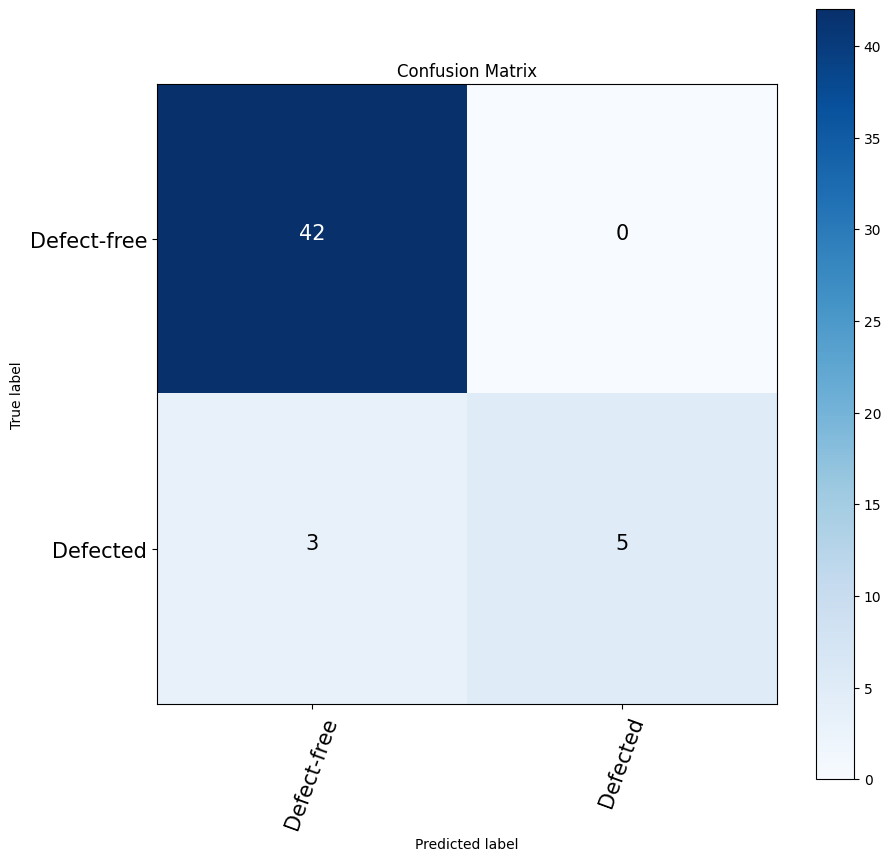

In [67]:
# vision.show_confusion_matrix(y_test_shuffled, y_pred_cnn, labels)
vision.show_confusion_matrix(np.argmax(y_test, axis=1), y_pred_abs, LABELS)

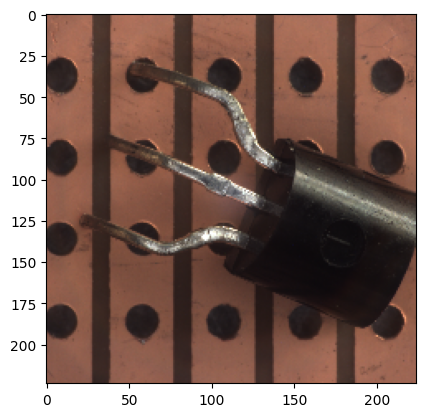

In [69]:
ix = 9

plt.imshow(X_test[ix]);

In [71]:
def show_GradCAM(gradCAM, test_image):
    class_id = np.argmax(resnet50_model.predict(np.expand_dims(X_test[ix], axis=0))[0])

    (heatmap, output) = gradCAM(np.expand_dims(X_test[ix], axis=0), X_test[ix]*255, class_id, alpha=0.4)

    fig = plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.imshow(X_test[ix])
    plt.title("Original")
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(heatmap)
    plt.title("Heatmap")
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(output)
    plt.title("Superimposed")
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 23ms/step


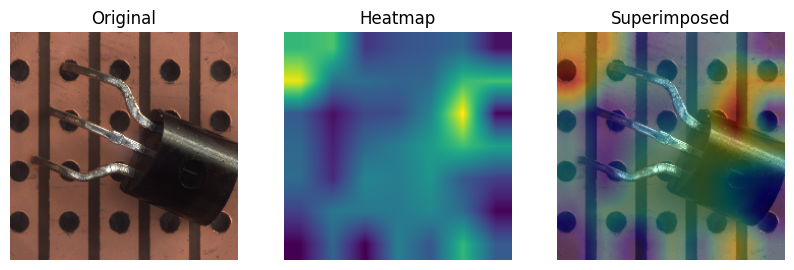

In [72]:
gradCAM = vision.GradCAM(resnet50_model)
show_GradCAM(gradCAM, X_test[ix])

1/1 [==============================] - 0s 25ms/step


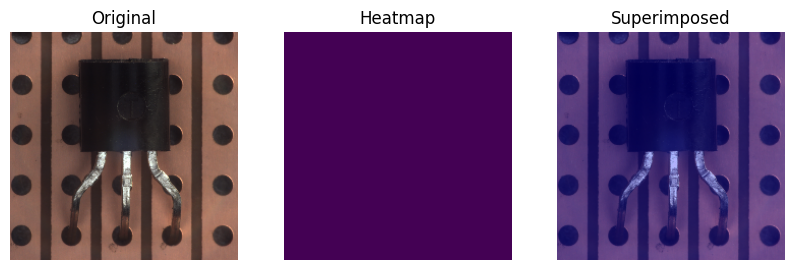

In [73]:
ix = 11
show_GradCAM(gradCAM, X_test[ix])

1/1 [==============================] - 0s 61ms/step


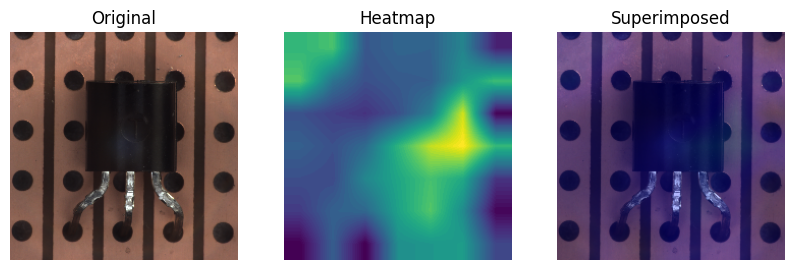

In [75]:
ix = 14
show_GradCAM(gradCAM, X_test[ix])

1/1 [==============================] - 0s 35ms/step


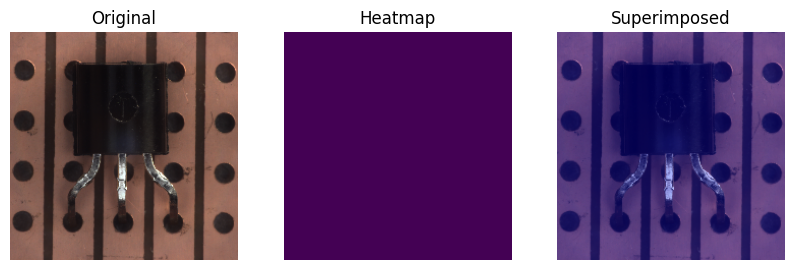

In [76]:
ix = 32
show_GradCAM(gradCAM, X_test[ix])

1/1 [==============================] - 0s 23ms/step


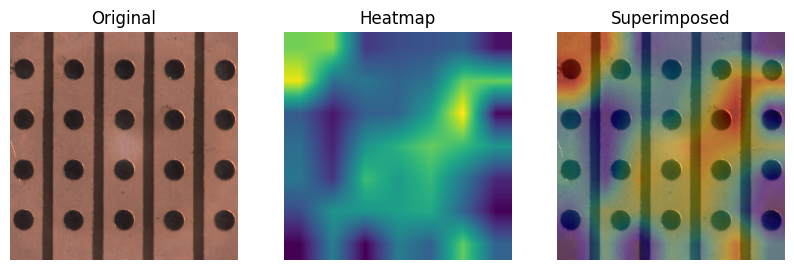

In [80]:
ix = 2
show_GradCAM(gradCAM, X_test[ix])

1/1 [==============================] - 0s 24ms/step


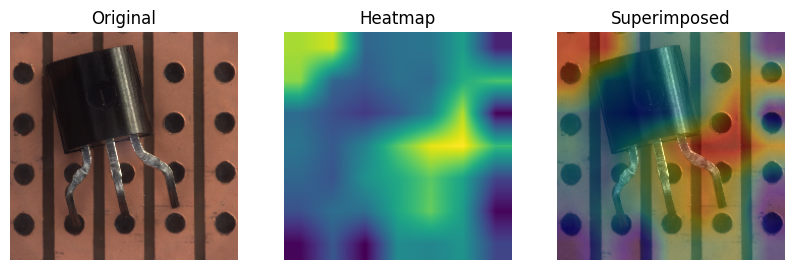

In [84]:
ix = 6
show_GradCAM(gradCAM, X_test[ix])

1/1 [==============================] - 0s 25ms/step


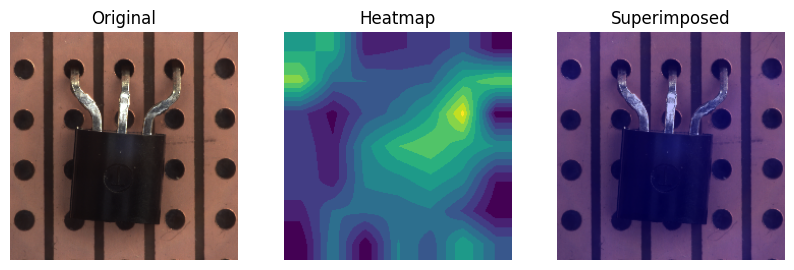

In [101]:
ix = 37
show_GradCAM(gradCAM, X_test[ix])

1/1 [==============================] - 0s 37ms/step


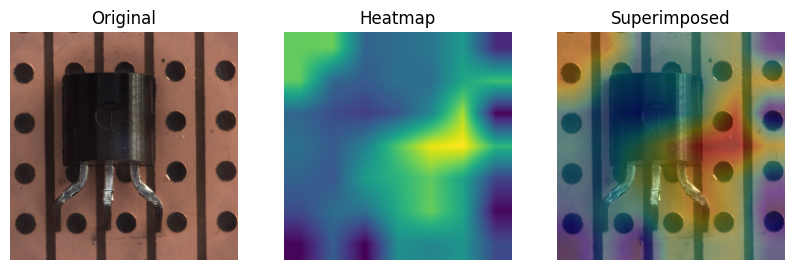

In [102]:
ix = 38
show_GradCAM(gradCAM, X_test[ix])

1/1 [==============================] - 0s 23ms/step


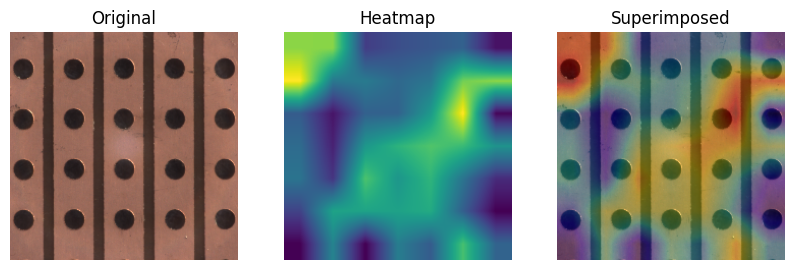

In [103]:
ix = 39
show_GradCAM(gradCAM, X_test[ix])

1/1 [==============================] - 0s 24ms/step


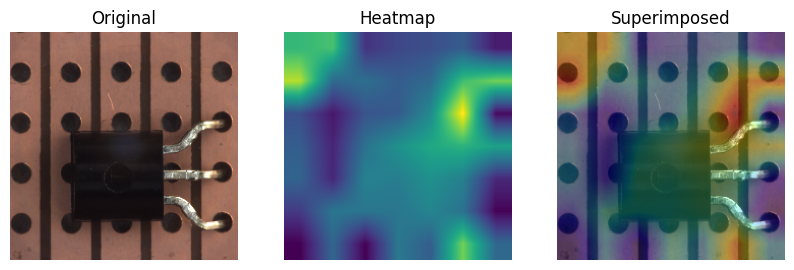

In [104]:
ix = 42
show_GradCAM(gradCAM, X_test[ix])

1/1 [==============================] - 0s 24ms/step


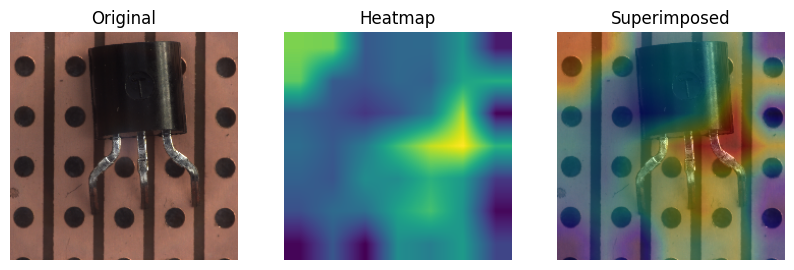

In [105]:
ix = 46
show_GradCAM(gradCAM, X_test[ix])

In [100]:
np.where(np.argmax(y_test, axis=1) == 1)

(array([ 2,  6,  9, 37, 38, 39, 42, 46]),)

In [99]:
np.argmax(y_test, axis=1)

array([0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0])